In [118]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os, glob
import numpy as np
import os
images = os.listdir("test_images/")
%matplotlib inline

print (images)

['solidYellowCurve2.jpg', 'solidWhiteCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve.jpg', 'solidWhiteRight.jpg', 'whiteCarLaneSwitch.jpg']


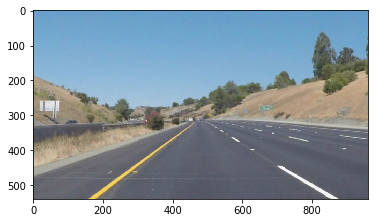

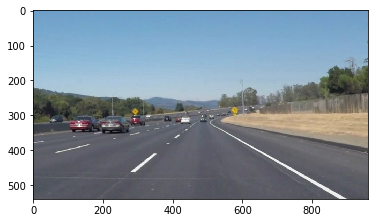

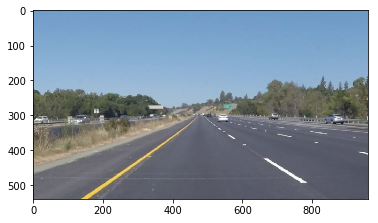

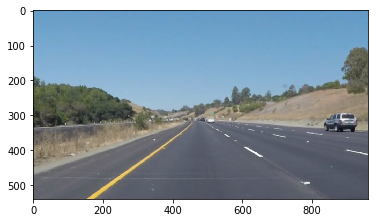

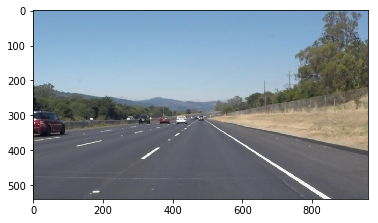

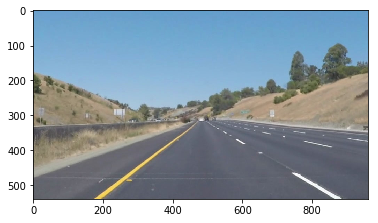

In [119]:
#display all images in the test image folder
for i, image in enumerate(images):
    img = mpimg.imread('test_images/' + image)
    plt.imshow(img)
    plt.show() 

In [120]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    Draws `lines` with `color` and `thickness`.
    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, 
                            np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0],img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

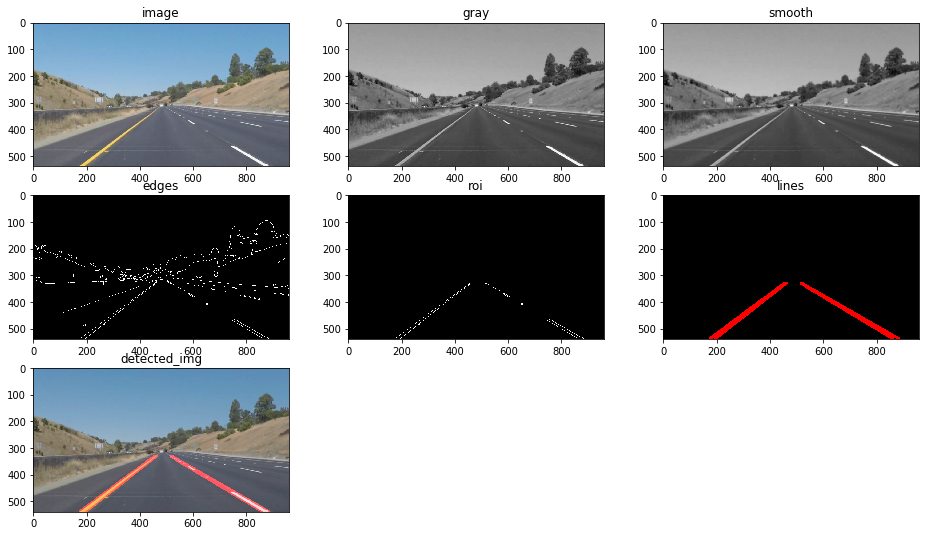

In [121]:
KERNEL_SIZE = 5
LOW_THRESHOLD = 50 # threshold for canny edge detector
HIGH_THRESHOLD = 150 # threshold for canny edge detector
height = canny_edges.shape[0]
width = canny_edges.shape[1]
interest = np.array([[(135, height),(900, height),(535, 330),(435, 330)]])

grayscale_image = grayscale(img)
smooth_image = gaussian_blur(grayscale_image, KERNEL_SIZE)
canny_edges = canny(smooth_image, LOW_THRESHOLD, HIGH_THRESHOLD)
roi = region_of_interest(canny_edges, [interest])
lines_image = hough_lines(roi, 1, np.pi/180, 32, 1, 200)

'''
lines_edges = hough_lines(roi,
                          rho=1,
                          theta=np.pi/180,
                          threshold=10,
                          min_line_len=10,
                          max_line_gap=15
                         )
'''
detected_img = weighted_img(lines_image, img, α=0.9, β=1., λ=0.)
plt.figure(figsize=[16, 9])
plt.subplot(3, 3, 1)
plt.title('image')
plt.imshow(img)
plt.subplot(3, 3, 2)
plt.title('gray')
plt.imshow(grayscale_image, cmap='gray')
plt.subplot(3, 3, 3)
plt.title('smooth')
plt.imshow(smooth_image, cmap='gray')
plt.subplot(3, 3, 4)
plt.title('edges')
plt.imshow(canny_edges, cmap='gray')
plt.subplot(3, 3, 5)
plt.title('roi')
plt.imshow(roi, cmap='gray')
plt.subplot(3, 3, 6)
plt.title('lines')
plt.imshow(lines_image, cmap='gray');
plt.subplot(3, 3, 7)
plt.title('detected_img')
plt.imshow(detected_img, cmap='gray');

In [122]:
def line_detect(img):
    grayscale_image = grayscale(img)
    smooth_image = gaussian_blur(grayscale_image, KERNEL_SIZE)
    canny_edges = canny(smooth_image, LOW_THRESHOLD, HIGH_THRESHOLD)
    roi = region_of_interest(canny_edges, [interest])
    lines_image = hough_lines(roi, 1, np.pi/180, 32, 1, 200)
    detected_img = weighted_img(lines_image, img, α=0.9, β=1., λ=0.)
    return detected_img

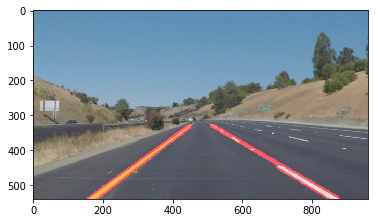

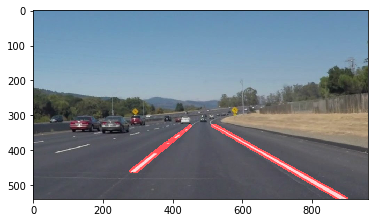

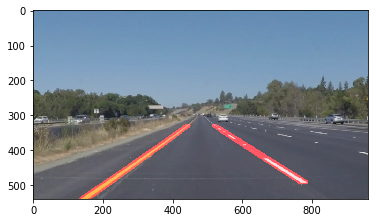

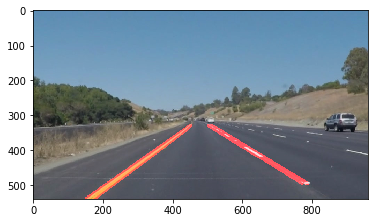

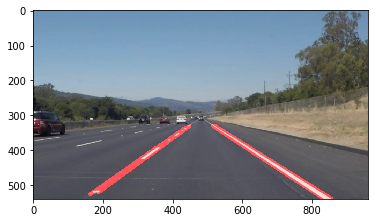

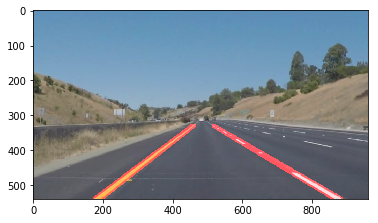

In [128]:
# apply line_detect function on all test images
for i, image in enumerate(images):
    img = mpimg.imread('test_images/' + image)
    detected_image = line_detect(img)
    plt.imshow(detected_image)
    plt.show() 

In [124]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [125]:
# apply line_detect function to test videos
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(line_detect)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 32.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.39 s, sys: 504 ms, total: 3.9 s
Wall time: 7.81 s


In [130]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [126]:
yellow_output = 'yellow.mp4'
clip1 = VideoFileClip("solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(line_detect)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:21<00:00, 31.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 10.7 s, sys: 1.62 s, total: 12.3 s
Wall time: 23.2 s


In [131]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))